# Particula tour

We have designed `particula` around object-oriented programming principles where physics entities inherit from each other.

1. It all starts with an `Environment` object (class) where temperature, pressure, and other derived properties are defined. For now, the two main derived properties are the dynamic viscosity and mean free path.
2. Then, the `Vapor` object inherits from `Environment` and adds its own properties, mainly vapor properties like radius and density, but also derived properties like the driving force of condensation.
3. The most involved object `Particle` builds on `Vapor` (and thus `Environment`). It is split into steps to isolate different components (e.g. making a distribution, making particle instances, calculating condensation, and calculating coagulation are all split into different objects that build on each other). In `Particle`, the idea is to form a fully equipped particle distribution, whose properties are readily available and calculated.
4. Up to `Particle`, there is no sense of a time dimension. To add one, we create the `Rates` object who takes as input the `Particle` object, thus explicitly allowing dynamics-specific calculations, or "rates".
5. Finally, a dynamic `Solver` object builds on `Rates` and propagates the `Particle` object in time.

## Setup

Let's first get the needed packages and set up our computational environment.

In [1]:
try:
    import particula, matplotlib
except ImportError:
    print("Setting up computational environment...")
    %pip install -U particula -qqq
    %pip install matplotlib -qqq

from particula.particle import Particle
from particula.rates import Rates
from matplotlib import pyplot as plt
import numpy as np

## Defining a distribution

Defining a distribution in `particula` is easy! Simply import the `Particle` class and pass some keyword arguments to it. Here we interested in a bimodal particle distribution, with different modes and different geometric standard deviations (`gsigma`) and different amplitude (`particle_number`). While at it, we might as well calculate rates and disabling the `lazy` execution so that we do not recalculate the rates at every call.


In [2]:
deets = {
    "mode": [10e-9, 70e-9],
    "gsigma": [1.6, 2.0],
    "nbins": 4000,
    "particle_number": [17/20, 3/20],
}
part_dist = Particle(**deets)
r = Rates(particle=part_dist, lazy=False)

We define a simple plot utility to plot some of the properties of this distribution.

In [3]:
def plot_some(x, y, grid="semilogx", title=None, label=None):
    """ plot y vs x with grid, providing title and label """
    if grid == "loglog":
        plt.loglog(x.m, y.m, label=label)
    else:
        plt.semilogx(x.m, y.m, label=label);
    if label is not None:
        plt.legend()
    plt.title(title)
    plt.xlabel(f"{x.u}"); plt.ylabel(f"{y.u}");

### Particle number concentration density

One way to think about this is to integrate the curve, that yields exactly 1e5 /cc which is the total number concentration. Try it! (Copy the code block below and execute it after or before the next cell.)

```python
np.trapz(part_dist.particle_distribution(), part_dist.particle_radius)
```

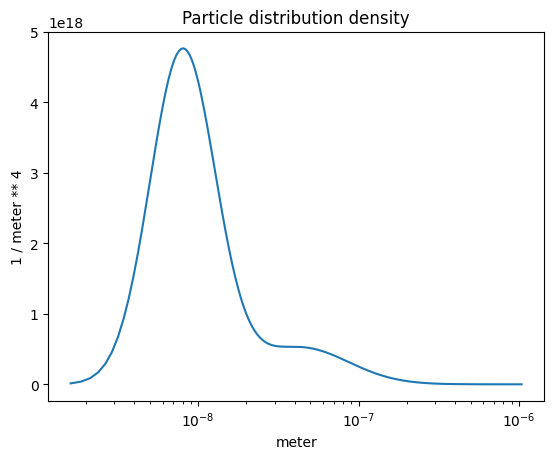

In [4]:
plot_some(
    x=part_dist.particle_radius,
    y=part_dist.particle_distribution(),
    title="Particle distribution density",
)

### The coagulation kernel

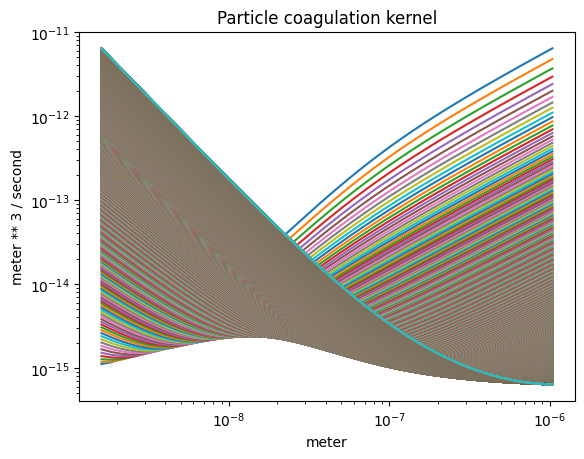

In [5]:
plot_some(
    x=part_dist.particle_radius,
    y=part_dist.coagulation(),
    title="Particle coagulation kernel",
    grid="loglog"
)

### The coagulation loss rate

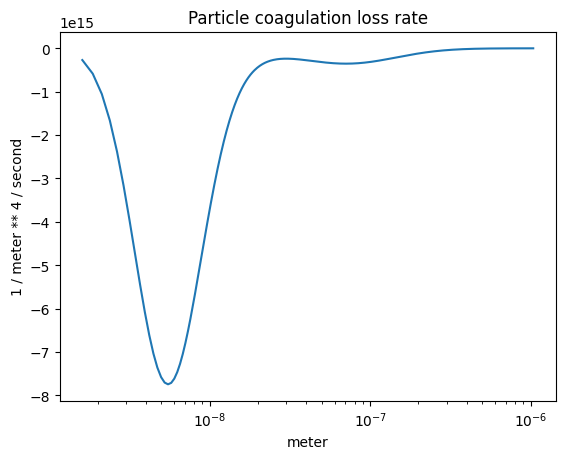

In [6]:
plot_some(
    x=part_dist.particle_radius,
    y=-r.coagulation_loss(),
    title="Particle coagulation loss rate",
)

### The coagulation gain rate

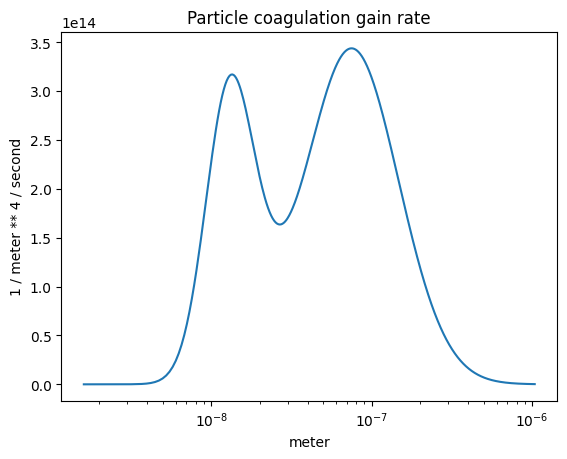

In [7]:
plot_some(
    x=part_dist.particle_radius,
    y=r.coagulation_gain(),
    title="Particle coagulation gain rate",
)

### The coagulation net rate

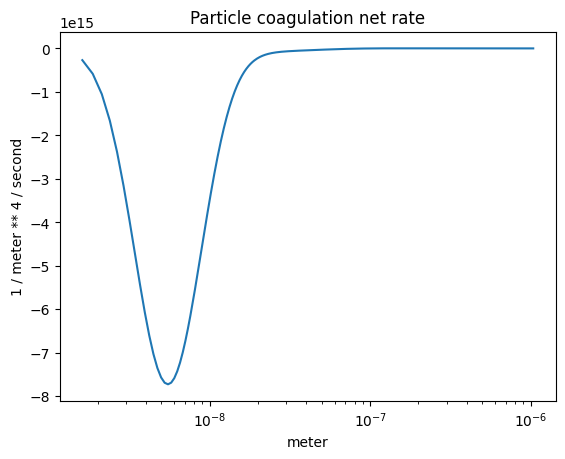

In [8]:
plot_some(
    x=part_dist.particle_radius,
    y=r.coagulation_rate(),
    title="Particle coagulation net rate",
)

### The condensation growth speed

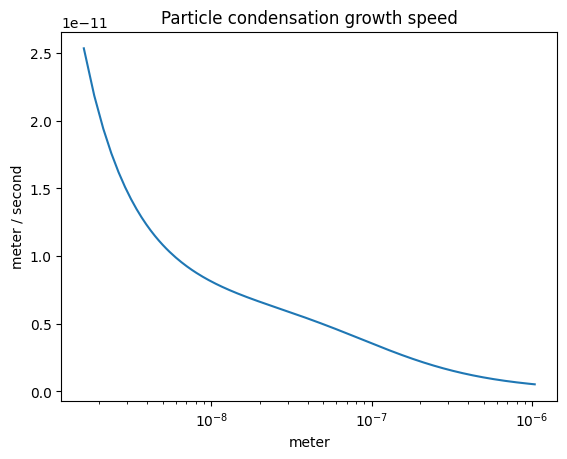

In [9]:
plot_some(
    x=part_dist.particle_radius,
    y=r.condensation_growth_speed(),
    title="Particle condensation growth speed",
)

### The condensation growth rate

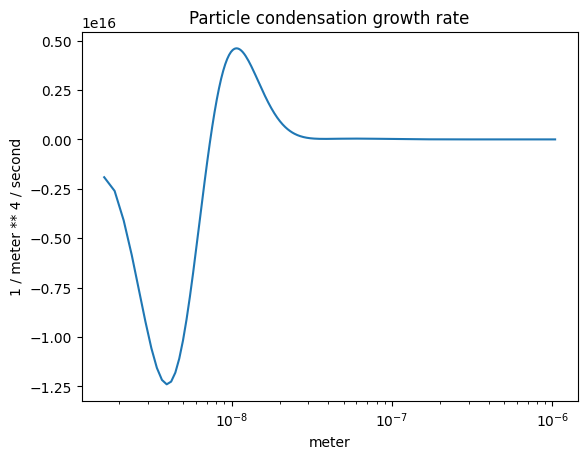

In [10]:
plot_some(
    x=part_dist.particle_radius,
    y=r.condensation_growth_rate(),
    title="Particle condensation growth rate",
)

### The condensation growth rate (volume-wise)

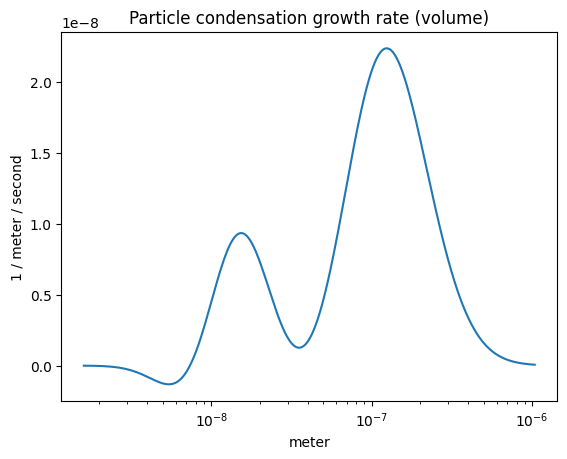

In [11]:
plot_some(
    x=part_dist.particle_radius,
    y=r.condensation_growth_rate()*part_dist.particle_radius**3,
    title="Particle condensation growth rate (volume)",
)

### The coagulation net rate (volume-wise)

Note the integration yields a small number, meaning the mass is conserved!

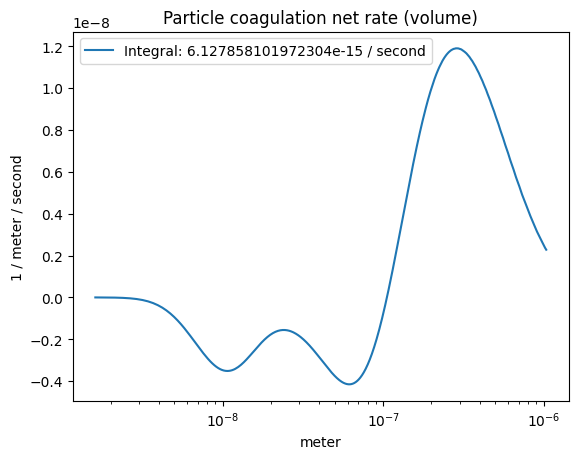

In [12]:
plot_some(
    x=part_dist.particle_radius,
    y=r.coagulation_rate()*part_dist.particle_radius**3,
    title="Particle coagulation net rate (volume)",
    label=f"Integral: {np.trapz(r.coagulation_rate()*part_dist.particle_radius**3, part_dist.particle_radius)}"
)

### A solver

If you are adventurous, you can even propagate the define distribution in time! We use a rather simple solver here, but it still takes time as it has to recalculate all the rates at every time step. We reduce the `nbins` to make it slightly faster, but it may not even run on a super tiny (free) machine.

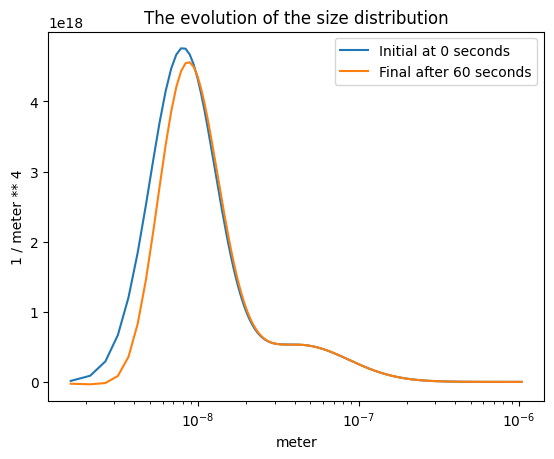

In [13]:
from particula.dynamics import Solver
deets = {
    "mode": [10e-9, 70e-9],
    "gsigma": [1.6, 2.0],
    "nbins": 2000,
    "particle_number": [17/20, 3/20],
}
part_dist = Particle(**deets)
r = Rates(particle=part_dist, lazy=True)
time_span = [0, 60]
s = Solver(particle=part_dist, time_span=time_span)
sols = s.solution()
plt.semilogx(part_dist.particle_radius.m, sols[0].m, label=f"Initial at {time_span[0]} seconds")
plt.semilogx(part_dist.particle_radius.m, sols[-1].m, label=f"Final after {time_span[-1]} seconds")
plt.xlabel(f"{part_dist.particle_radius.u}")
plt.ylabel(f"{sols[0].u}")
plt.title("The evolution of the size distribution")
plt.legend();

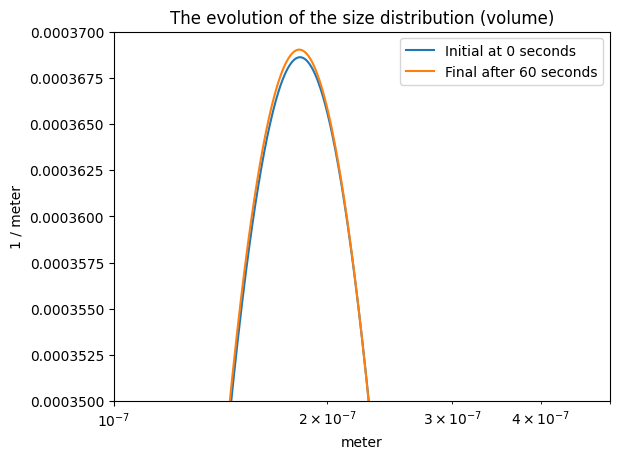

In [14]:
plt.semilogx(
    part_dist.particle_radius.m,
    sols[0].m*part_dist.particle_radius.m**3,
    label=f"Initial at {time_span[0]} seconds"
)
plt.semilogx(
    part_dist.particle_radius.m,
    sols[-1].m*part_dist.particle_radius.m**3,
    label=f"Final after {time_span[-1]} seconds"
)
plt.legend()
plt.xlabel(f"{part_dist.particle_radius.u}")
plt.ylabel(f"{sols[0].u*part_dist.particle_radius.u**3}")
plt.title("The evolution of the size distribution (volume)")
plt.xlim([1e-7, 5e-7]); plt.ylim([35e-5, 37e-5]);